In [1]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install scipy

Requirement already up-to-date: pip in /anaconda3/lib/python3.7/site-packages (19.1.1)


In [2]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt
import random

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [3]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, \
    ForeignKey, Float, LargeBinary
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    prediction    = Column(LargeBinary, nullable=True)
    year          = Column(Integer, nullable=True)
    month         = Column(Integer, nullable=True)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")


class Job(BASE):
    """Job model for DB and redis. Has information on the status and result of
        redis queue job."""
    __tablename__ = 'job'
    id            = Column(BigInteger, primary_key=True)
    result        = Column(String, nullable=False)
    datetime      = Column(DateTime, nullable=False)

In [34]:
DAY_OF_WEEK  = 0
DAY_OF_MONTH = 1
HOUR_OF_DAY  = 2

data_type  = DAY_OF_WEEK

do_gridsearch = False

if data_type == DAY_OF_WEEK:
    SCALING_FACTOR = 1000.
    OPERATOR = '*'
elif data_type == DAY_OF_MONTH:
    SCALING_FACTOR = 1000.
    OPERATOR = '*'
else:
    raise ValueError("Unexpected data type:", data_type)

def scale_data(X):
    if data_type == DAY_OF_WEEK:
        X *= SCALING_FACTOR
    elif data_type == DAY_OF_MONTH:
        X *= SCALING_FACTOR  # This we will use with the count(severity) SQL query
    else:
        raise ValueError('Unexpected data type:', data_type)
    return X

def descale_data(X):
    if analysis_type == COUNT_CRIME_TYPES:
        X /= SCALING_FACTOR
    elif analysis_type == COUNT_SEVERITY:
        X /= SCALING_FACTOR  # This we will use with the count(severity) SQL query
    else:
        raise ValueError('Unexpected data type:', data_type)
    return X

class GetData(object):
    def go(self, SESSION, start_year, end_year):
        if data_type == DAY_OF_WEEK:
            SQL_QUERY = \
                f'''
                    SELECT
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.dow,
                        crimetype.ppo,
                        crimetype.violence,
                        COUNT(*)/AVG(block.population) AS category
                    FROM incident
                    INNER JOIN block ON incident.blockid = block.id
                    INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                        AND block.population > 0
                        AND incident.cityid = 1
                        AND incident.year >= {start_year}
                        AND incident.year <= {end_year}
                    GROUP BY
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.dow,
                        crimetype.ppo,
                        crimetype.violence
                '''
        elif data_type == HOUR_OF_DAY:
            SQL_QUERY = \
                f'''
                    SELECT
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.hour,
                        crimetype.ppo,
                        crimetype.violence,
                        COUNT(*)/AVG(block.population) AS category
                    FROM incident
                    INNER JOIN block ON incident.blockid = block.id
                    INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                        AND block.population > 0
                        AND incident.cityid = 1
                        AND incident.year >= {start_year}
                        AND incident.year <= {end_year}
                    GROUP BY
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.hour,
                        crimetype.ppo,
                        crimetype.violence
                '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [35]:
def fill_data(X, y, r, start_year, end_year, blockid_dict, data_type):
    
    def day_of_month(x):
        return x.day - 1

    def hour_of_day(x):
        return x.hour

    def encode(row):
        ppo_dict = {'PERSONAL': 0, 
                    'PROPERTY': 1, 
                    'OTHER': 2}
        viol_dict = {'VIOLENT': 1, 
                     'NON_VIOLENT': 0}
        res = []
        res.extend([r[0], r[1], r[2], r[3], r[4], ppo_dict[r[5]], viol_dict[r[6]], r[7]])
        
        return res
        
    # Output: blockid month dow hour ppo violence = value
    #
    #                       0  incident.blockid,
    #                       1  incident.datetime,
    #                       2  incident.year,
    #                       3  incident.month,
    #                       4  incident.dow   OR  incident.hour,
    #                       5  crimetype.ppo,     'PERSONAL', 'PROPERTY', 'OTHER'  3
    #                       6  crimetype.violence 'VIOLENT', 'NONVIOLENT'          2
    #                       7  value at this location

    r = encode(r)
    if r[2] == end_year:
        if data_type == DAY_OF_WEEK:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, r[4], r[5], r[6]] = float(r[7])
            #                                            ^^^^        ^^^^
            #                                            dow         risk
        elif data_type == HOUR_OF_DAY:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, r[4], r[5], r[6]] = float(r[7])
            #                                             ^^^^^^^^^^^^^^^         ^^^^
            #                                               hour of day           risk
        else:
            raise ValueError('Unsupported data type:', data_type)
    else:
        if data_type == DAY_OF_WEEK:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, r[4], r[5], r[6]] = float(r[7])
        elif data_type == HOUR_OF_DAY:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, r[4], r[5], r[6]] = float(r[7])
        else:
            raise ValueError('Unsupported data type:', data_type)

In [26]:
def process_data(data, start_year, end_year, blockid_dict, data_type):

    if data_type == DAY_OF_WEEK:
        X = np.zeros((len(blockid_dict), 24, 7, 3, 2))
        y = np.zeros((len(blockid_dict), 12, 7, 3, 2))
    elif data_type == HOUR_OF_DAY:
        X = np.zeros((len(blockid_dict), 24, 24, 3, 2))
        y = np.zeros((len(blockid_dict), 12, 24, 3, 2))
    else:
        raise ValueError('data_type not supported:', data_type)
    
    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            fill_data(X, y, r, start_year, end_year, blockid_dict, data_type)

    #     print('Data value counts:', pd.Series(y.flatten()).value_counts())

    X = scale_data(X)
    y = scale_data(y)

    #     for i in range(24):
    #         X[:, i, -1] = (start_year*12+i) / (2000 * 12)
        
    return X, y

In [27]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year, train_blockid_dict,
               testing_start_year, testing_end_year, test_blockid_dict,
               data_type):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        print(type(training_data))
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        train_blockid_dict,
                                        data_type)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      test_blockid_dict,
                                      data_type)

    return X_train, X_test, y_train, y_test

## Day of week analysis for each month of each block id

In [28]:
# start month = 3, end_month = 2 (months are 0-indexed)
#   X: 4/2017 -> 3/2019 actual date
#   y: 4/2019 -> 3/2020 actual date
#
X_test_start_month = 0
X_test_end_month   = 0
X_test_start_year  = 2016
X_test_end_year    = 2018

TRAIN_NUM_BLOCKIDS = TEST_NUM_BLOCKIDS = 801

TRAIN_BLOCKIDS = random.sample(list(range(1,802)), k=TRAIN_NUM_BLOCKIDS)   
train_blockid_dict = {}
for ind, blockid in enumerate(TRAIN_BLOCKIDS ):
    train_blockid_dict[blockid] = ind
        
TEST_BLOCKIDS = random.sample(list(range(1,802)), k=TEST_NUM_BLOCKIDS)    
test_blockid_dict = {}
for ind, blockid in enumerate(TEST_BLOCKIDS ):
    test_blockid_dict[blockid] = ind

In [29]:
def plot_output(y, y_pred, dataset_type, x_label, y_label):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    plt.legend(labels=['data', 'prediction'], prop={'size': 20})
    plt.show()

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

random.seed(101)

def get_predictions(X_train, y_train, X_test, y_test, 
                    x_label, y_label, model, do_gridsearch=False):
    
    def print_data_info(data, data_name):
        flat = data.flatten()
        print('Number of data points:', len(flat))
        print('Number of non-zero elements:', len(flat[flat > 0.0]))
        print('Percentage of non-zero elements:', len(flat[flat > 0.0])/len(flat))

        pd.Series(flat).hist(bins=[0.25, 0.5, 1.0, 1.5, 2.5, 5.0, 10, 15, 20]);
        plt.title(f'Histogram of {data_name}')
        plt.show()
    
    print_data_info(y_test, 'y_test')
    print('Correlation between y_train and y_test:\n', 
          np.corrcoef(y_train.flatten(), y_test.flatten()))
          
    def mult_of_shapes(X):
        return X.shape[1] * X.shape[2] * X.shape[3] * X.shape[4]
    
    X_train = X_train.reshape((TRAIN_NUM_BLOCKIDS, mult_of_shapes(X_train)))
    y_train = y_train.reshape((TRAIN_NUM_BLOCKIDS, mult_of_shapes(y_train)))
    X_test = X_test.reshape((TEST_NUM_BLOCKIDS, mult_of_shapes(X_test)))
    y_test = y_test.reshape((TEST_NUM_BLOCKIDS, mult_of_shapes(y_test)))

    print('y_test shape after reshaping:', y_test.shape)
    
    if do_gridsearch == True:
        # For regressors:
        param_grid = {
            'estimator__n_estimators':  [80, 100, 120],
            'estimator__max_depth': [2, 3, 4, 5, 6],
        }

        gridsearch = GridSearchCV(model,
                                  param_grid=param_grid, 
                                  scoring='neg_mean_squared_error', 
                                  cv=3, n_jobs=-1,
                                  return_train_score=True, verbose=10)
        model = gridsearch

    model.fit(X_train, y_train)

    best_training_score = model.score(X_train, y_train)
    best_testing_score  = model.score(X_test, y_test)

    print(f'  Best training score:', -best_training_score)
    print(f'  Best testing score: ', -best_testing_score)

    if do_gridsearch == True:
        best_model_params = model.cv_results_['params'][model.best_index_]
        print('Best Grid Search model:', best_model_params)

    y_pred = model.predict(X_test)
    print('mean_squared_error:', mean_squared_error(y_test, y_pred))
          
    plot_output(y_test, y_pred, 'Testing', x_label, y_label)

    def relative_percent_difference(y_true, y_pred):
        return 1 - np.absolute((y_true - y_pred) / (np.absolute(y_true) + np.absolute(y_pred)))
    
    return y_test, y_pred, relative_percent_difference(y_test, y_pred)

## Day of week analysis for each block ID

<class 'list'>
(801, 24, 7, 3, 2) (801, 12, 7, 3, 2) (801, 24, 7, 3, 2) (801, 12, 7, 3, 2)
Number of data points: 403704
Number of non-zero elements: 116267
Percentage of non-zero elements: 0.2880006143114757


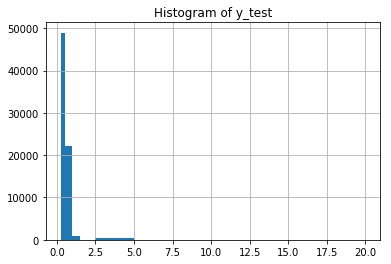

Correlation between y_train and y_test:
 [[1.         0.00865456]
 [0.00865456 1.        ]]
y_test shape after reshaping: (801, 504)


In [ ]:
%%time

X_train_dow, X_test_dow, y_train_dow, y_test_dow = \
        ready_data(2015, 2017, train_blockid_dict,
                   X_test_start_year, X_test_end_year, test_blockid_dict,
                   DAY_OF_WEEK)

print(X_train_dow.shape, y_train_dow.shape, X_test_dow.shape, y_test_dow.shape)
model = MultiOutputRegressor(RandomForestRegressor(max_depth=3, n_estimators=80))
y_test_dow, y_pred_dow, rpd_dow = get_predictions(X_train_dow, y_train_dow, X_test_dow, y_test_dow, 
                                                  'day of week for each month', 
                                                  f'crime type count / population {OPERATOR} {SCALING_FACTOR}', 
                                                  model, do_gridsearch=do_gridsearch)

In [ ]:
plot_output(y_test_dow.flatten()[:100], y_pred_dow.flatten()[:100], 'Test', 
            'day of week for each month', 'crime count')

## Hour of day analysis for each block ID

In [ ]:
%%time

X_train_hod, X_test_hod, y_train_hod, y_test_hod = \
    ready_data(2015, 2017, train_blockid_dict,
               X_test_start_year, X_test_end_year, test_blockid_dict,
               DAY_OF_MONTH)

print(X_train_hod.shape, y_train_hod.shape, X_test_hod.shape, y_test_hod.shape)

model = MultiOutputRegressor(RandomForestRegressor(max_depth=5, n_estimators=120))

y_test_hod, y_pred_hod, rpd_hod = get_predictions(X_train_hod, y_train_hod, X_test_hod, y_test_hod, 
                                                  'day of month for each month', 
                                                  f'crime type count / population {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                                                  model, do_gridsearch=do_gridsearch)

## Weight and combine predictions into one array

In [ ]:
NUM_BLOCKIDS       = 801
NUM_MONTHS_IN_YEAR = 12
NUM_DAYS_IN_WEEK   = 7
NUM_HOURS_IN_DAY   = 24

crime_rate = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY))
y_test_result = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY))

# Each of the relative percent difference arrays can contain NaN's.
# This is because if both y_pred and y_true were zeros, their
# addition is also zero, and we cannot divide by this zero.
# Here we replace NaN's to get around that issue.
# Since we want to have the highest weight to those values that
# have the same y_pred and y_true, we will give the largest value
# from our array to these NaNs.

def replace_nans(a):
    b = a.copy()
    for row in range(a.shape[0]):
        # max_of_row = np.max(row)
        for col in range(a.shape[1]):
            if np.isnan(a[row][col]):
                b[row][col] = 1.0
    return b

rpd_dow = replace_nans(rpd_dow)
rpd_hod = replace_nans(rpd_hod)

print('Number of nans after replacement:', np.isnan(rpd_dow).sum())

# Returns number of days in a month
def days_in_month(year, month):
    p = pd.Period(f'{year}-{month}-1')
    return p.days_in_month

# Day of week returns 0-based day value
def day_of_week(dt):
    return dt.weekday()

end_year = X_test_end_year

for blockid in range(NUM_BLOCKIDS):
    for month in range(1, NUM_MONTHS_IN_YEAR + 1):
        
        count = np.zeros(NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY)
        for day in range(1, days_in_month(end_year, month) + 1):
            for hour in range(24):
                dow  = day_of_week(datetime(end_year, month, day))

                weight_dow = rpd_dow[blockid, (month - 1)*dow]
                weight_hod = rpd_hod[blockid, (month - 1)*hour]
                weight_sum = weight_dow + weight_hod
                
                crime_rate[blockid, month-1, dow * hour] += \
                    (y_pred_dow[blockid, (month - 1)*dow] * weight_dow +
                     y_pred_hod[blockid, (month - 1)*hour] * weight_hod) / weight_sum
                
                y_test_result[blockid, month-1, dow*hour] += \
                    (y_test_dow[blockid, (month - 1)*dow] * weight_dow +
                     y_test_hod[blockid, (month - 1)*hour] * weight_hod) / weight_sum
                
                count[dow * hour] += 1
        crime_rate[blockid, month-1, dow * hour] /= count[dow * hour]
        y_test_result[blockid, month-1, dow * hour] /= count[dow * hour]

crime_rate_descaled = descale_data(crime_rate)
crime_rate_descaled = np.nan_to_num(crime_rate_descaled)
crime_rate = crime_rate_descaled.copy()
y_test_result = descale_data(y_test_result)
y_test_result = np.nan_to_num(y_test_result)

In [ ]:
y = y_test_dow_times_hour.flatten()
r = risks.flatten()
print('Number of zeros in y_test_dow_times_hour:', len(y[y == 0.0]), 'out of:', len(y))
print('Number of zeros in risks:', len(r[r == 0.0]), 'out of:', len(r))

In [ ]:
def plot_y_vs_ypred(y, y_pred):
    fig = plt.figure(figsize=(10, 8))

    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel('dow * hour', fontsize=16)
    plt.ylabel('crime count / population * 1000', fontsize=18)
    plt.title('Test dataset', fontsize=18)
    if analysis_type == COUNT_CRIME_TYPES:
        plt.legend(labels=['count', 'predicted count'], prop={'size': 20})
    elif analysis_type == COUNT_SEVERITY:
        plt.legend(labels=['count', 'predicted count'], prop={'size': 20})
    else:
        plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()
plot_y_vs_ypred(y_test_result, risks)

In [ ]:
plot_y_vs_ypred(y_test_result[0][0], risks[0][0])